# Twitter Data Analysis on BTC

### Yawen Han & Huiyuan Huang

## List of Content
1. Overview
2. Introduction
3. Initial Data Exploration
4. Text Cleaning
5. Word Cloud
6. Sentiment Analysis
7. ML: Text & Sentiment
8. BTC Market vs. Twitter Attributes
9. Machine Learning Models
10. LSTM
11. Reference

In [1]:
import numpy as np
import pandas as pd
import sys

import warnings
warnings.simplefilter("ignore")

## 1.Overview

Twitter data is the most comprehensive source of live, public conversation worldwide. Unlike other social platforms, almost every user’s tweets are completely public and pullable, which provides a large amount of data to run analytics on. Twitter data is also pretty detailed from time, content to location. Twitter’s API allows users to do complex queries like pulling every tweet about a certain topic within the past 7 days, or searching a certain topic by a list of search words.

Twitter’s REST, streaming, and Enterprise API enable programmatic analysis of data in real-time or back to the first Tweet in 2006. By performing the Twitter data analysis, it helps to get insight into audience, market movements, emerging trends, key topics, breaking news, and much more. With the twitter Search API, this project focused on 1) applying data science techniques on Twitter data to understand the motivations, interests, and attitudes of Twitter users about bitcoin market; 2) exploring the relationship between Twitter data and bitcoin market data to inform business decisions.


The “Twitter Data Analysis on Bitcoin” project focused on the data research and analysis of Twitter data on bitcoin markets, to identify potential patterns and correlations for business insights. In the project, works were carried out in the discovery cycle including background research (identify the topics and related resources), preliminary data exploration (explore data and verify data quality), text cleaning (data cleaning and transformation), modeling and discussions.
 
#### 1.1 Read in json, export as csv 

In [3]:
import json

# read JSON data as the dataframe 
## 1) 1st data collection: 0810 - 0820 (10 days duration)
json_path = '../data/btc_data_extraction/database/0810-0820data.json'
initial_db = pd.read_json(json_path, orient='records')

In [4]:
# export the 0810-0820 as csv file
initial_db.to_csv('../data/btc_data_extraction/database/0810_0820initial_db.csv', index = False)


#### 1.2 Update database to 0826

In [5]:
# 2) 2nd data collection: 0821 - 0825 (5 days duration)
json_path2 = '../data/btc_data_extraction/database/0826update.json'
#Read JSON data into the datastore variable
update_db_0826 = pd.read_json(json_path2, orient='records')
# export the new DB
update_db_0826.to_csv('../data/btc_data_extraction/database/0821_0826update_db.csv',index = False)


In [6]:
initial_db = pd.read_csv('../data/btc_data_extraction/database/0810_0820initial_db.csv')
update_db_0826 = pd.read_csv('../data/btc_data_extraction/database/0821_0826update_db.csv')

# combine initial with update to get 0810-0826 
temp_db = pd.concat([initial_db,update_db_0826])
# export the new DB(update to 0826)
temp_db.to_csv('../data/btc_data_extraction/database/0810_0826update_db.csv',index = False)


#### 1.3  Read in the Twitter DataSet (0810-0826)

In [7]:
# read in the updated datasbase
initial_db2 = pd.read_csv('../data/btc_data_extraction/database/0810_0826update_db.csv')

## 2. Introduction

#### 2.1 Twitter Data Collection

- Duration: 08/10/2019 to 08/25/2019, 15 days in total
- Search Keywords: "bitcoin", "btc"
- Data Format: json
- Size: ~ 2 Million data
- Contains: 31 attributes

The project mainly performed analysis on two datasets: Twitter dataset and Bitcoin market dataset. The Twitter dataset contains around 2 million records with 31 attributes, gathering all the tweets with keywords “bitcoin” or “btc” from 8/10/2019 to 8/25/2019 (15 days in total). The twitter data were collected through Twitter Search API with results in JSON format. The Twitter dataset contains informed attributes, like “created_at”, “full_text”, “retweet_count”, “favorited_count”, “lang”, “place”, etc. 

In [8]:
# get the attribute info for twitter data
initial_db2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195490 entries, 0 to 195489
Data columns (total 31 columns):
contributors                 13 non-null object
coordinates                  165 non-null object
created_at                   195480 non-null object
display_text_range           195480 non-null object
entities                     195477 non-null object
extended_entities            61751 non-null object
favorite_count               195477 non-null float64
favorited                    195477 non-null object
full_text                    195477 non-null object
geo                          168 non-null object
id                           195477 non-null object
id_str                       195477 non-null object
in_reply_to_screen_name      17143 non-null object
in_reply_to_status_id        15013 non-null float64
in_reply_to_status_id_str    15011 non-null float64
in_reply_to_user_id          17143 non-null float64
in_reply_to_user_id_str      17143 non-null float64
is_quote_status 

In [9]:
# first 5 records in twitter dataset
initial_db2.head()

contributors coordinates           created_at display_text_range  \
0          NaN         NaN  2019-08-20 23:59:58           [0, 138]   
1          NaN         NaN  2019-08-20 23:59:52           [0, 223]   
2          NaN         NaN  2019-08-20 23:59:40           [0, 201]   
3          NaN         NaN  2019-08-20 23:59:27            [0, 81]   
4          NaN         NaN  2019-08-20 23:59:25            [0, 85]   

                                            entities  \
0  {'hashtags': [{'text': 'BTC', 'indices': [7, 1...   
1  {'hashtags': [{'text': 'bitcoin', 'indices': [...   
2  {'hashtags': [{'text': 'BTC', 'indices': [140,...   
3  {'hashtags': [{'text': 'BitQuark', 'indices': ...   
4  {'hashtags': [{'text': 'btc', 'indices': [48, ...   

                                   extended_entities  favorite_count  \
0                                                NaN             0.0   
1                                                NaN             9.0   
2                                                NaN             0.0   
3                                                NaN             0.0   
4  {'media': [{'id': 1163963770470916096, 'id_str...             0.0   

  favorited                                          full_text  geo  ...  \
0     False  $BTC | #BTC - bitcoin's Current Price: ▼ $1077...  NaN  ...   
1     False  🚨 CoinSpice Live is on the air, streaming now!...  NaN  ...   
2     False  Prices update in $USDT every 1 hour:\n\n$BTC -...  NaN  ...   
3     False  Mine #BitQuark at https://t.co/KVIMisuynC 0% m...  NaN  ...   
4     False  This is insane COINBASE! I just received 1.935...  NaN  ...   

  possibly_sensitive quoted_status quoted_status_id  quoted_status_id_str  \
0                  0           NaN              NaN                   NaN   
1                  0           NaN              NaN                   NaN   
2                NaN           NaN              NaN                   NaN   
3                  0           NaN              NaN                   NaN   
4                  0           NaN              NaN                   NaN   

   retweet_count  retweeted  \
0            2.0      False   
1            4.0      False   
2            0.0      False   
3            0.0      False   
4            0.0      False   

                                              source truncated  \
0  <a href="https://crypto.press" rel="nofollow">...     False   
1  <a href="https://mobile.twitter.com" rel="nofo...     False   
2  <a href="https://coinmarketcap.com" rel="nofol...     False   
3  <a href="http://wwww.bitquark.info" rel="nofol...     False   
4  <a href="https://mobile.twitter.com" rel="nofo...     False   

                                                user withheld_in_countries  
0  {'id': 24411256, 'id_str': '24411256', 'name':...                   NaN  
1  {'id': 1012928761254178816, 'id_str': '1012928...                   NaN  
2  {'id': 1157616094510604289, 'id_str': '1157616...                   NaN  
3  {'id': 2340798698, 'id_str': '2340798698', 'na...                   NaN  
4  {'id': 1159993144710221824, 'id_str': '1159993...                   NaN  

[5 rows x 31 columns]

#### 2.2 BTC Market Data

- Duration: 08/10/2019 to 08/25/2019, 15 days in total
- Time Interval: every 1 min
- Data Format: csv
- Contains: 8 attribute
- Area: North American (Gemini)
- Website: http://www.cryptodatadownload.com/data/northamerican/

The Bitcoin market dataset contains 21,600 records with 8 attributes, gathering btc market data in each minute from 8/10/2019 to 8/25/2019 (15 days in total). In this project, the “Close” price was used as the price for each minute when performing the analysis.

In [10]:
# load BTC market dataset
btc_market = pd.read_csv("../data/btc_price_volume/gemini_BTCUSD_1min_0827.csv")


In [11]:
# get the attribute info for bitcoin market dataset
btc_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65499 entries, 0 to 65498
Data columns (total 8 columns):
Unix Timestamp    65499 non-null int64
Date              65499 non-null object
Symbol            65499 non-null object
Open              65499 non-null float64
High              65499 non-null float64
Low               65499 non-null float64
Close             65499 non-null float64
Volume            65499 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.0+ MB


In [12]:
# first 5 records in bitcoin market dataset
btc_market.head()

Unix Timestamp                 Date  Symbol      Open      High       Low  \
0   1566864180000  2019-08-27 00:03:00  BTCUSD  10374.59  10374.59  10365.85   
1   1566864120000  2019-08-27 00:02:00  BTCUSD  10379.19  10379.19  10374.59   
2   1566864060000  2019-08-27 00:01:00  BTCUSD  10367.23  10379.19  10367.23   
3   1566864000000  2019-08-27 00:00:00  BTCUSD  10367.23  10367.23  10367.23   
4   1566863940000  2019-08-26 23:59:00  BTCUSD  10367.23  10367.23  10367.23   

      Close    Volume  
0  10365.85  0.044524  
1  10374.59  0.537898  
2  10379.19  1.497519  
3  10367.23  0.000000  
4  10367.23  0.000000

## 3. Preliminary Data Exploration
- Top 10 Languages
- Top 20 Countries
- Top 30 Hashtags

#### 3.1. Top 10 Languages

In addition to the “Unknown” language, the top 3 languages used most when users talking about bitcoin markets are “English”, “Japanese”, and “Spanish”, indicating that users who speaks these three languages are more interested in the bitcoin market.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# load btc market data
pre_db = pd.read_csv('../data/btc_data_extraction/database/0810_0826update_db.csv')


In [14]:
# map the abbrivation to the full name for each language
dict1 = {'en': 'English', 'ja': 'Japanese', 'es': 'Spanish', 'tr':'Turkish', 'fr': 'French', 'de':"German",
       'in': 'Indonesian', 'pt': "Portuguese", 'nl': 'Dutch', 'und': 'Unknown'}
# map the language abbreviation to the full text
for index, row in pre_db.iterrows():
    if row['lang'] in dict1:
        pre_db.loc[index,'lang'] = dict1[row['lang']]
        #print(row['lang'])

In [15]:
# export the updated btc market dataset
pre_db.to_csv('../data/btc_data_extraction/database/0829Update_Language_Name.csv',
                                    index = False)
pre_db_lang = pd.read_csv('../data/btc_data_extraction/database/0829Update_Language_Name.csv')


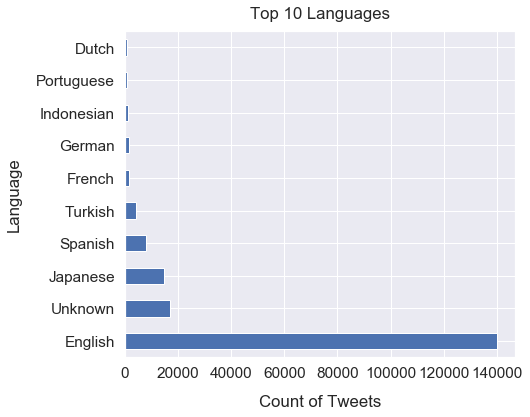

In [16]:
# language distribution (bar chart)
sns.set(font_scale=1.4)
pre_db_lang['lang'].value_counts()[:10].plot(kind='barh', figsize=(7, 6), rot=0)
plt.xlabel("Count of Tweets", labelpad=14)
plt.ylabel("Language", labelpad=14)
_ = plt.title("Top 10 Languages", y=1.02)

#### 3.2 Top 20 Countries/Areas
- Too much "Unknown": been removed 

The top 5 countries/areas are “United States”, “United Kingdom”, “Turkey”, “Canada”, and “Nigeria”, indicating that users in these five areas are probably more interested in the bitcoin market. What’s more, in the top 20 countries, we can see most countries are from North American and Europe, with some from Asia and Africa.

In [17]:
import math
from ast import literal_eval
import numpy as np

# extract the country info from the "place" column (in dict format)
ls = []
for index, row in pre_db.iterrows():
    if row['place'] is np.nan or row['place']== "False":
        #row['country'] = None
        ls.append("Unknown")
    else:
        ls.append(literal_eval(row['place'])['country'])
            
# assign the country column
pre_db['country'] = ls

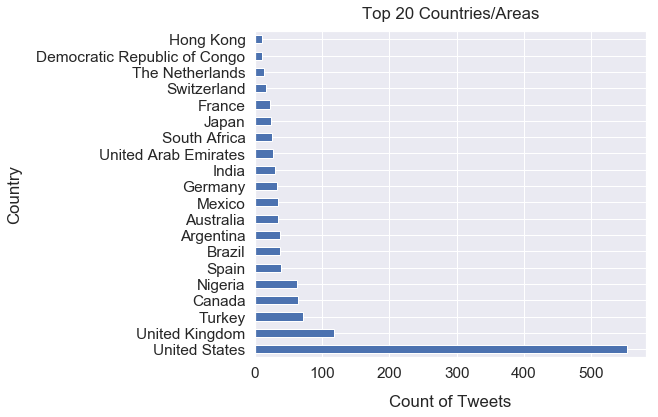

In [18]:
# country distribution (bar chart)
pre_db['country'].value_counts()[1:21].plot(kind='barh', figsize=(7, 6), rot=0)
plt.xlabel("Count of Tweets", labelpad=14)
plt.ylabel("Country", labelpad=14)
_ = plt.title("Top 20 Countries/Areas", y=1.02)

#### 3.3 Top 30 Hashtags

In addition to the words we used to search for the tweets (bitcoin,btc), the top 5 hashtags are “crypto”, “blockchain”, “crypto-currency”, “ethereum”, “eth” and “xrp”, indicating these words are most likely been attached with bitcoin market on Twitter. What’s more, in the top 30 hashtags, most tags are the cryptocurrency names.

In [19]:
# extract the hashtags_list from the column "entities" (in dict format)
hashtag_ls = []
for index, row in pre_db.iterrows():
    if row['entities'] is np.nan:
        hashtag_ls.append("Unknown")
    else:
        hashtag_ls.append(literal_eval(row['entities'])['hashtags'])               
# extract hashtag_list
pre_db['hashtag_list'] = hashtag_ls

In [20]:
hashtags=[]
# extract the list of hashtags from the dict format
for index, row in pre_db.iterrows():
     if(row['lang'] == 'English'):
        if row['hashtag_list'] == "Unknown":
            #row['hashtags'] = ["Unknown"]
            hashtags.append("Unknown")
        else:
            temp = [literal_eval(str(item))['text'].lower() for item in row['hashtag_list']]
            #row['hashtags'] = temp 
        hashtags.extend(temp)
            

In [21]:
import matplotlib.font_manager as font_manager

# set the font to be applicable for japanses words
font = font_manager.FontProperties(fname='../Font/fonts-japanese-mincho.ttf')
fontP = font_manager.FontProperties()
fontP.set_size(14)

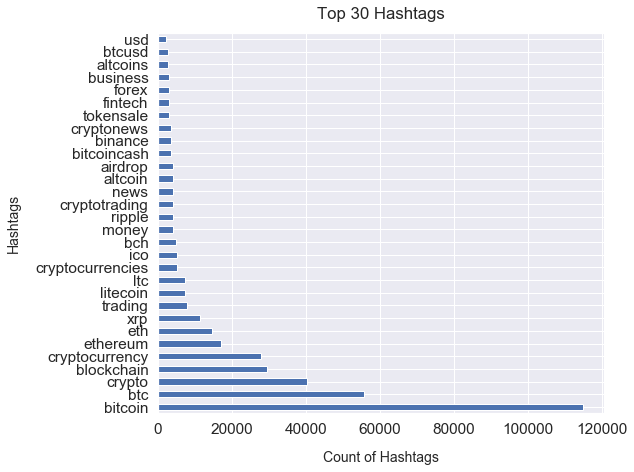

In [22]:
# hashtags distribution (bar chart)
pd.Series(hashtags).value_counts()[:30].plot(kind='barh', figsize=(8, 7), rot=0)
plt.xlabel("Count of Hashtags", labelpad=14, fontproperties=fontP)
plt.ylabel("Hashtags", labelpad=14, fontproperties=fontP)
_ = plt.title("Top 30 Hashtags", y=1.02)

#### 3.4 Drop columns/attributes

In [23]:
# drop the columns that has wrong values
drop_index = initial_db2[initial_db2['contributors'].notnull()].index
initial_db2.drop(drop_index, inplace=True)

In [24]:
# drop the columns that not english
drop_index_non_en = initial_db2[initial_db2['lang'] != 'en'].index
initial_db2.drop(drop_index_non_en, inplace=True)

## 4. Text-Cleaning

Before performing further analysis on text data, we need to clean the text for each tweet. From the “full_text” column in Table1, we can observe that there are emoji & emoticons, punctuations, upper case, links and numbers in the text.

To help the computer understand our text, we need to vectorize the text, which is just a method to convert words into long lists of numbers, which might hold some sort of complex structuring, only to be understood by a computer using some sort of machine learning, or data mining algorithm. But even before that, we need to perform a sequence of operations on the text, so that our text can be “cleaned” out. Main steps of text data cleansing are listed below with explanations:

In [25]:
import nltk
# nltk.download('wordnet')

In [26]:
# import these modules 
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
# nltk.sentiment.vader

ps = PorterStemmer() # stemming
wordnet_lemmatizer = WordNetLemmatizer()  #Lemmatization


#### 4.1 Remove Emoticons & Emojis

Although some emoji and emoticons can somewhat provide users attitudes, the sentiment analysis library we used here can only handle the limited built-in emoji and emoticons. Thus, we just simply remove them here.

In [27]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [28]:
print(emoticons)

{':-p', 'XD', 'xp', ':b', '<3', '>:/', '=/', ':-[', '>:-)', ':-||', '>:(', ':L', ':p', 'x-p', ':-c', '>:\\', ':)', '=p', '>:[', ';)', 'XP', '8D', '>:P', 'X-P', ':>', ':-))', ':*', ':P', ':<', ':S', ':\\', ':^)', '=L', ':-<', ':-P', '>:)', 'xD', ':{', ':c', ':-D', ':}', ":')", ':]', '=D', '=]', ':(', 'x-D', ';(', '=\\', ':[', ':o)', ':-b', '>;)', ":'(", '=-3', ':@', 'X-D', '8-D', '8)', ':-/', ":'-)", '=-D', '=3', ':c)', ':3', ':-(', '>.<', ":'-(", ':-)', '=)', ':^*', ':D'}


In [29]:
import re
# Emojis pattern
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)


In [30]:
emoji_pattern

re.compile(r'[😀-🙏🌀-🗿🚀-\U0001f6ff\U0001f1e0-🇿✂-➰Ⓜ-🉑🤦-🤷𐀀-\U0010ffff\u200d♀-♂☀-⭕⏏⏩⌚〰️]+',
re.UNICODE)

#### 4.2 Remove Punctuations

In the following analysis, the model learns word embedding without considering order of words, and all the sentences will be tokenized as words. The punctuations were not necessary here, thus been removed.

In [31]:
# punctuations pattern
punctuation_pattern = string.punctuation + "▼"
punctuation_pattern

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~▼'

#### 4.3 Remove Stop_Words + Search_Words

Some extremely common words which return vast amount of unnecessary information were excluded from the vocabulary entirely, because these words taking up unnecessary space or valuable processing time.

In [33]:
from wordcloud import WordCloud, STOPWORDS
stopwords_re = set(STOPWORDS)
update_list = ["btc", "bitcoin","blockchain", "crypto","cryptocurrency"]
stopwords_re.update(update_list)
print(stopwords_re)

{'during', 'was', 'for', 'my', "you've", 'i', 'it', 'does', 'cannot', 'more', 'since', 'very', 'all', "you'll", 'such', 'what', 'myself', 'his', 'be', 'http', "didn't", 'about', 'com', 'her', 'just', 'r', "we've", 'were', 'are', 'herself', 'ours', "mustn't", 'own', 'can', 'our', 'himself', "can't", 'www', 'however', "isn't", 'that', 'cryptocurrency', "they'd", 'no', "i'd", "he'd", 'a', 'ourselves', 'from', 'further', 'yours', 'then', 'we', 'me', 'at', 'nor', "wouldn't", 'and', "aren't", 'below', 'on', "haven't", 'out', 'once', 'blockchain', 'after', "who's", "don't", "we're", 'they', "doesn't", "how's", 'have', "when's", 'crypto', 'some', 'also', 'same', "what's", 'do', "couldn't", "here's", 'shall', 'under', 'any', 'otherwise', 'theirs', "they'll", 'ought', "weren't", "let's", "why's", 'having', 'only', 'few', "that's", 'like', 'has', 'the', 'to', 'up', 'would', 'there', "hadn't", 'its', 'should', 'before', 'hers', 'in', "you're", 'why', 'off', 'over', 'if', 'itself', 'too', 'being', 

## 4.4 Other Operations
- Lemmatization
- Lower Case
- Remove links
- Remove numbers

Other steps of text data cleansing are performed, including 1) lemmatization, 2) convert upper case to lower case, 3) remove links, 4) remove numbers.

In [34]:
'''
clean_tweets()
contains: remove links, tokenize, reomve non-ASCII chars, convert to lower case, remove stop_words, remove 
'''
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    # remove links
    tweet = re.sub(r'http\S+', '', tweet)
   
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the import re
   
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'([0-9])\w+','',tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    
    word_tokens = word_tokenize(tweet)
 
    
    #tweet = re.sub(r"\b\w+\b",' ', tweet)
 
    #filter using NLTK library append it to a string
    #filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    #looping through conditions
    for w in word_tokens:
        # convert to lower case
        w = w.lower()
        # lemmanization
        w = wordnet_lemmatizer.lemmatize(w)
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in punctuation_pattern:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    

In [35]:
# apply the clean_tweet() function on the clean_text column 
initial_db2['clean_text'] = initial_db2['full_text'].apply(clean_tweets)

In [36]:
# show last 5 clean_text 
initial_db2['clean_text'].tail()

195483    bitcoin btc price currently usd eur 's number ...
195485    suffer bitcoin hit time remotely toggle rig ho...
195486    btc price decreased buying amp selling btc eth...
195488    list popular blockchain platform explained sim...
195489    octobot alert bitcoin symbol btcusdt result lo...
Name: clean_text, dtype: object

## 5. Word Count (WordCloud)

The word cloud on the left shows the top 600 frequent words/tokens appeared in all the text of twitter dataset. The bigger and the bolder a word appears in the word cloud, the more often this word appears in the text.


In [38]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread
#from imageio import imread
#from arabic_reshaper import arabic_reshaper
#from bidi.algorithm import get_display


In [40]:
# join tweets to a single string
text = ' '.join(row['clean_text'] for index, row in initial_db2.iterrows() if row['lang'] == 'en')
text = re.findall(r"\b\w+\b", text, flags=re.UNICODE)
text = " ".join(t for t in text)
#text = text.decode("utf-8")
#text = arabic_reshaper.reshape(text)
#text = get_display(arabic_reshaper.reshape(text))

In [41]:
stopwords = set(STOPWORDS)
update_list = ["btc", "bitcoin","blockchain", "crypto","cryptocurrency"]
stopwords.update(update_list)

In [42]:
# read the mask image
# taken from
twitter_mask = imread('../Image/twitter_mask.png', flatten=True)


wc = WordCloud(background_color="white", max_words=600, mask=twitter_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue',
               width=1800, height=1400, regexp=r"\b\w+\b",
              font_path='../Font/Symbola.ttf').generate(text)


/anaconda3/lib/python3.7/site-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"
/anaconda3/lib/python3.7/site-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


/anaconda3/lib/python3.7/site-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


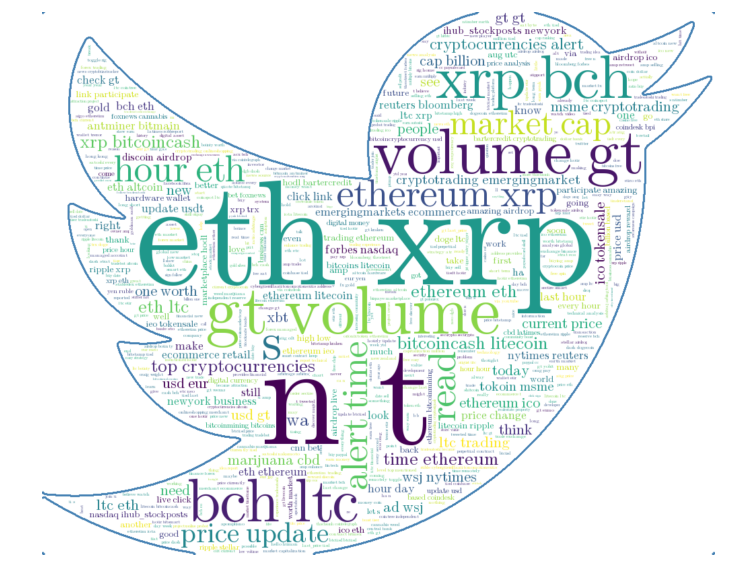

In [43]:
# show
plt.figure(figsize=(20,10))
_ = plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")


it was observed that the most frequent words are “eth”, “xrp”, “gt”, “volume”, “bch”, “ltc”, etc. In all these words, expect “volume”, all other words are other cryptocurrency names. It seems like users on twitter always talking other cryptocurrencies along with btc. Among these cryptocurrency, “eth”, “xrp”, “gt”, “bch”, and “ltc” are relatively more popular than others.

## 6. Sentiment Analysis

Sentiment Analysis is the process of computationally determining whether a piece of writing is positive, negative or neutral, it helps us to understand the twitter users’ attitudes towards the bitcoin market. In the project, the NLTK-VADER library was applied on each tweet text to label its corresponding semantic orientation as either positive(>0), negative(<0), or neutral(=0).


In [45]:
# load the vader library for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


In [46]:
# get sentiment score applying the vaderSentiment functions
initial_db2['sentiment'] = initial_db2['full_text'].apply(analyzer.polarity_scores)

In [47]:
initial_db2['sentiment_comp'] = [c['compound'] for c in initial_db2['sentiment']]
initial_db2['sentiment_pos'] = [c['pos'] for c in initial_db2['sentiment']]
initial_db2['sentiment_neg'] = [c['neg'] for c in initial_db2['sentiment']]

In [48]:
# calculated
initial_db2["user"]=[eval(x) for x in initial_db2["user"]]
initial_db2["id"]=[user["id"] for user in initial_db2["user"]]
initial_db2["followers"]=[user["followers_count"] for user in initial_db2["user"]]
#initial_db2.to_csv("with_followers_count.csv")

In [49]:
initial_db2.to_csv("../data/btc_data_extraction/database/with_followers_fulltextscore.csv")

#### 6.1.  BTC Market Data Preprocess

The website that contains the NorthAmerican btc price for each minute:  
http://www.cryptodatadownload.com/data/northamerican/

Since the Bitcoin market data is based on the minute level, the twitter data are also need to processed in the same time level to combine the two datasets together as one dataframe. A couple of attributes are aggregated in Bitcoin Market dataset: 1) 'retweet_count' are summed up in each minute; 2) 'favorite_count' are summed up in each minute; 3) 'tweet_count' are counted for each minute; 4) 'full_text' are appended together in each minute.

Instead of invetigating the real price of bitcoin, what we focused is the price/volume change in btc. Thus, two new columnes are added as "price_trend", "volume_trend" with values "1" and "0", representing the price/volume change of current minute compared with last minute.

In [50]:
from datetime import datetime

# load BTC market dataset
btc_market = pd.read_csv("../data/btc_price_volume/gemini_BTCUSD_1min_0827.csv")

# convert the Date to datetime format
btc_market['Date'] = btc_market['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
initial_db2['created_at'] = initial_db2['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [51]:
#reset date-time as the index
initial_db2 = initial_db2.set_index('created_at')

# group the initial_db2 for every 1 monute to be consistent with the market data
reformated_db = pd.DataFrame()
reformated_db['tweet_count'] = initial_db2['retweet_count'].resample('T').count()
reformated_db['retweet_count'] = initial_db2['retweet_count'].resample('T').sum()# sum up the retweet
reformated_db['favorite_count'] = initial_db2['favorite_count'].resample('T').sum()# sum of the favorite
reformated_db['clean_text'] = initial_db2['clean_text'].resample('T').apply(lambda x: ' '.join(x))# append the clean_text
reformated_db = reformated_db.reset_index()

In [52]:
# merge the market_db and reformated_db
combined_df = pd.merge(reformated_db, btc_market, left_on='created_at', right_on='Date',how='inner')

In [53]:
# get the price and volume change as the new columns
combined_df['Price_Trend'] = combined_df['Close'].shift() <= combined_df['Close']
combined_df['Volume_Trend'] = combined_df['Volume'].shift() <= combined_df['Volume']
# repalce the values
combined_df['Price_Trend'] = combined_df['Price_Trend'].replace({True:1, False:0})
combined_df['Volume_Trend'] = combined_df['Volume_Trend'].replace({True:1, False:0})

In [54]:
combined_df['Price_Trend'].value_counts()

1    11680
0     7088
Name: Price_Trend, dtype: int64

In [55]:
combined_df['Volume_Trend'].value_counts()

1    10110
0     8658
Name: Volume_Trend, dtype: int64

In [56]:
combined_df.tail()

created_at  tweet_count  retweet_count  favorite_count  \
18763 2019-08-25 23:55:00            2           21.0            83.0   
18764 2019-08-25 23:56:00            1            0.0             2.0   
18765 2019-08-25 23:57:00            3            2.0             2.0   
18766 2019-08-25 23:58:00            3            0.0             2.0   
18767 2019-08-25 23:59:00            6            2.0            19.0   

                                              clean_text  Unix Timestamp  \
18763  boe governor carney regulating cryptocurrencie...   1566777300000   
18764  doge token dogecoin v2 better every aspect dog...   1566777360000   
18765  crypto news brazil week review xbt btc bitcoin...   1566777420000   
18766  total marketcap bitcoin dominance ethereum dom...   1566777480000   
18767  imf santander bank bank england come warned bi...   1566777540000   

                     Date  Symbol      Open      High       Low     Close  \
18763 2019-08-25 23:55:00  BTCUSD  10097.91  10097.91  10086.15  10086.15   
18764 2019-08-25 23:56:00  BTCUSD  10086.15  10117.98  10086.15  10114.21   
18765 2019-08-25 23:57:00  BTCUSD  10114.21  10150.00  10114.21  10150.00   
18766 2019-08-25 23:58:00  BTCUSD  10150.00  10157.47  10141.16  10141.16   
18767 2019-08-25 23:59:00  BTCUSD  10141.16  10143.01  10135.59  10135.59   

         Volume  Price_Trend  Volume_Trend  
18763  0.024114            0             1  
18764  0.011173            1             0  
18765  5.640344            1             1  
18766  2.184094            0             0  
18767  0.300100            0             0

#### 6.2 drop the rows with no text

In [57]:
# drop the columns that not english
drop_index_non_text = combined_df[combined_df['clean_text'] == ''].index
combined_df.drop(drop_index_non_text, inplace=True)

#### 6.3 Generate Sentiment Scores

VADER has been found to be quite successful when dealing with social media texts. It does not require any training data but a generalized standard sentiment lexicon, and returns the Positive(0~1), Neutral(0~1), Negative(0~1), and Compound(- 1~1) sentiment scores. The Positive, Negative and Neutral scores represent the proportion of text that falls in these categories. The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive). Table 4 above shows part of the sentiment scores.

In [58]:
# get sentiment score applying the vaderSentiment functions
combined_df['sentiment'] = combined_df['clean_text'].apply(analyzer.polarity_scores)
combined_df['sentiment_comp'] = [c['compound'] for c in combined_df['sentiment']]
combined_df['sentiment_pos'] = [c['pos'] for c in combined_df['sentiment']]
combined_df['sentiment_neg'] = [c['neg'] for c in combined_df['sentiment']]

In [59]:
# extract the diffremt sentiment - pos, neu, neg
pos_combined_df = combined_df[combined_df['sentiment_comp'] > 0]
neu_combined_df = combined_df[combined_df['sentiment_comp'] == 0]
neg_combined_df = combined_df[combined_df['sentiment_comp'] < 0]

#### 6.4 Sentiment Distribution
- most of tweets seems to be postive
- only a small amount of tweets tend to be neutral ot negative

The twitter text data was divided into 3 groups: Positive, Neutral, and Negative. According to the bar chart, most of tweets have a positive score, while only a small amount of tweets tend to be neutral or negative. 

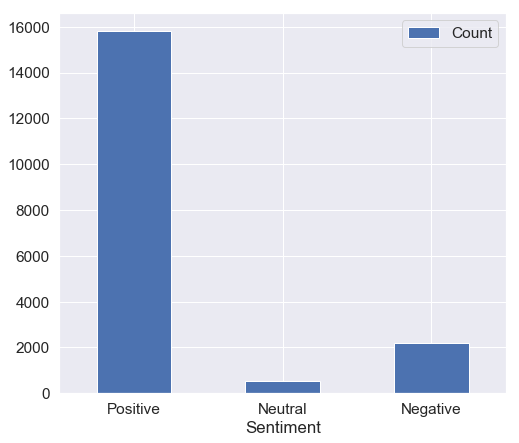

In [60]:
d = {'Sentiment': ['Positive', 'Neutral', 'Negative'], 
     'Count': [len(pos_combined_df), len(neu_combined_df),len(neg_combined_df)]}
pd.DataFrame(d).set_index('Sentiment').plot(kind='bar', figsize=(8, 7), rot=0)
_ = plt.xlabel("Sentiment")


#### 6.5 WordCloud Comparison 

Generating the word clouds for 3 groups to check the most frequent words used among twitter users with different attitudes. 

We can observe that there is not a lot difference between Positive word cloud and Neutral word cloud – most words are cryptocurrency names. While in Negative word cloud, there appear a big “new” and “s”, which are probably good indicators for a negative tweet.


In [63]:
'''
define the function generate_wordcloud to get the wordcloud
for certain input dataframe, then save the output image with 
given title in the given file_path

para: 
    df:input dataframe, with a column "clean_text"
    file_path: String, the file path to save output image
    title: String, the title of output image
       
'''
def generate_wordcloud(df,file_path, title):
    # join tweets to a single string
    text = ' '.join(row['clean_text'] for index, row in df.iterrows())
    text = re.findall(r"\b\w+\b", text, flags=re.UNICODE)
    text = " ".join(t for t in text)
    
    # read the mask image
    wc = WordCloud(background_color="white", max_words=100, #mask=twitter_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue',regexp=r"\b\w+\b",
               width=1000, height=800, font_path='../Font/CabinSketch-Bold.ttf').generate(text)

    # show
    #fig = plt.figure(figsize=(20,10))
    _ = plt.imshow(wc, interpolation='bilinear')
    _ = plt.axis("off")
    _ = plt.title(title,fontsize= 20)
    plt.savefig(file_path, dpi=300)
    
    return fig
    

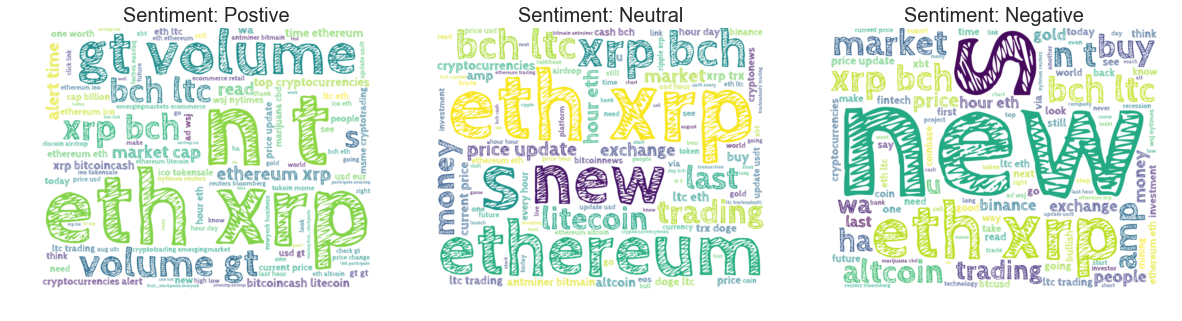

In [64]:
# 1. Plot in same line, this would work
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
fig_pos = generate_wordcloud(pos_combined_df, '../Image/my_twitter_wordcloud_pos.png', 'Sentiment: Postive')
ax2 = fig.add_subplot(1,3,2)
fig_neu = generate_wordcloud(neu_combined_df, '../Image/my_twitter_wordcloud_neu.png', 'Sentiment: Neutral')
ax3 = fig.add_subplot(1,3,3)
fig_neg = generate_wordcloud(neg_combined_df, '../Image/my_twitter_wordcloud_neg.png','Sentiment: Negative')

## 7. ML: Tweets Text & BTC Market
- Two Approaches for text vectorization:   
(1)   Count Vectorizor   
(2)   Tf-Idf Vectorizor


- Two types of Market Data:   
(1) BTC Price   
(2) BTC Volume  


- ML Model:  
Logistic Regression

With the processed data on-hand, this section focused on investigating the words most relevant to price change. As the BTC Market dataset is summarized every 1 minute, the twitter text data were also combined together for each minute. Comparing the current closing price with the last minute, the price change was labeled as “go up”(assigned as 1), or “go down”(assigned as 0). Then the LogisticRegression models are trained and tested, with text as input, price change as label. (Note: to handle time-series data, the train-test-split were not shuffled, and validated in time-order.)

Two approaches were applied when tokenizing and vectorizing the text: 1)Count Vectorizer and 2) Tf-Idf Vectorizer. They both convert the text data into vectors, but Count Vectorizer only counts the number of times a word appears in the document, while Tf-Idf Vectorizer also considers the overall document weightage of a word.



In [65]:
# load_files returns a bunch, containing training texts and training labels
#text_trainval, y_trainval = combined_df['clean_text'], combined_df['Close']
text_trainval, y_trainval = combined_df['clean_text'], combined_df['Price_Trend']

from sklearn.model_selection import train_test_split, cross_val_score

#train_test_split
text_train, text_val, y_train, y_val = train_test_split(
    text_trainval, y_trainval,  shuffle=False)


#### 7.1 Count Vectorizer & BTC Price

- score: 0.5630

Count Vectorizer implements both tokenization and count of occurrence which results in biasing in favor of most frequent words, this ends up in ignoring rare words which helps to process the data more efficiently. Fed the count vectorized data into LogisticRegression model then tested, the score was 0.5631. 

The LogisticRegression Model assigned each word a coefficient, the value of which indicated the effect of that word for the bitcoin price change. For example, the leftmost word “study” had the greatest positive value, indicating the occurrence of this word most likely asscociated with the price “go up”. Even both good & bad words can be observed in “go up” and “go down” part, it also provided the words twitter users mostly likely to use along with price change in bitcoin.


In [66]:
from sklearn.feature_extraction.text import CountVectorizer

# count vectirizer
vect = CountVectorizer(max_features=20000, token_pattern=r"\b\w+\b")
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import numpy as np

# use logistic regression to train the text-price model
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_val, y_val)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5630397236614854

In [68]:
'''
define the function plot_important_features  
that shows the top n words with greatest absolute coefficients in each side
para:
    coef: a 1-D numerical array with coefficients
    feature_names: a Steing list contains feature names
    top_n: the top n absolute coefficients in postive/negative side
            top_n = 20 as default
    ax: the plot axis
    rotation: the rotation angle for x label
'''

def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

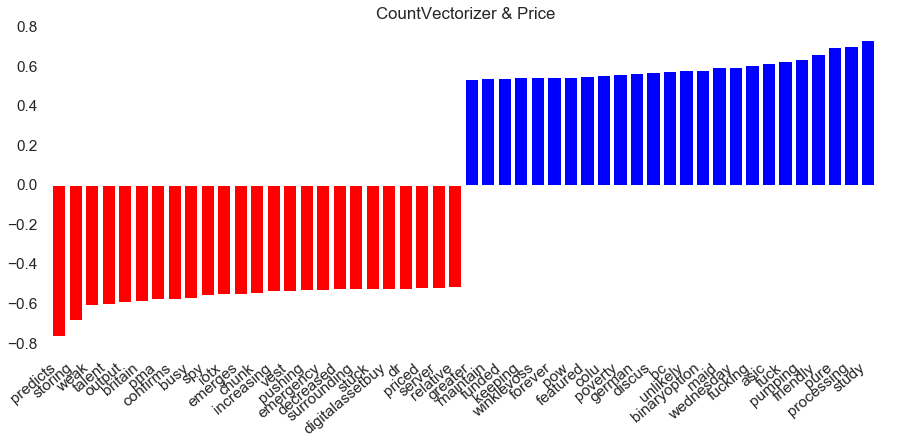

In [69]:
# plot the top 25 greatest absolute coefficient words in each side
feature_names = vect.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr.coef_.ravel(), np.array(feature_names), top_n=25, rotation=40)
_ = plt.title("CountVectorizer & Price")
ax = plt.gca()

#### 7.2 Tfidf Vectorizer & Price
- Score: 0.6079

In a corpus, several common words make up lots of space which carry little information, only the count of words will shallow the real interesting terms of the document. Tf-Idf Vectorizer penalize the frequency with how often they appear in the document. Fed the tf-idf vectorized data into LogisticRegression model then tested, the score was 0.6079, which was better than count vectorizer. 

The LogisticRegression Model assigned each word a coefficient, the value of which indicated the effect of that word for the bitcoin price change. For example, the leftmost word “cointelegraph” had the greatest positive value, indicating the occurrence of this word most likely associated with the price “go up”. The tf-idf model gave a better test score than count model, and there were a lot of common words in two models, such as “study”, “happy”, “unlikely”......, which re-indicating the most frequent words associated with btc price change.

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# tf-idf model
tfidf = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf.fit_transform(text_train)
X_val_tfidf = tfidf.transform(text_val)

In [71]:
# use Logistic Regression to train the text-price model
lr_tfidf = LogisticRegression().fit(X_train_tfidf, y_train)
lr_tfidf.score(X_val_tfidf, y_val)

0.6079447322970639

In [72]:
# get feature names
vac = tfidf.vocabulary_ 
sorted_vac = sorted(vac.items(), key=lambda kv: kv[1])
feature_names = [x[0] for x in sorted_vac]

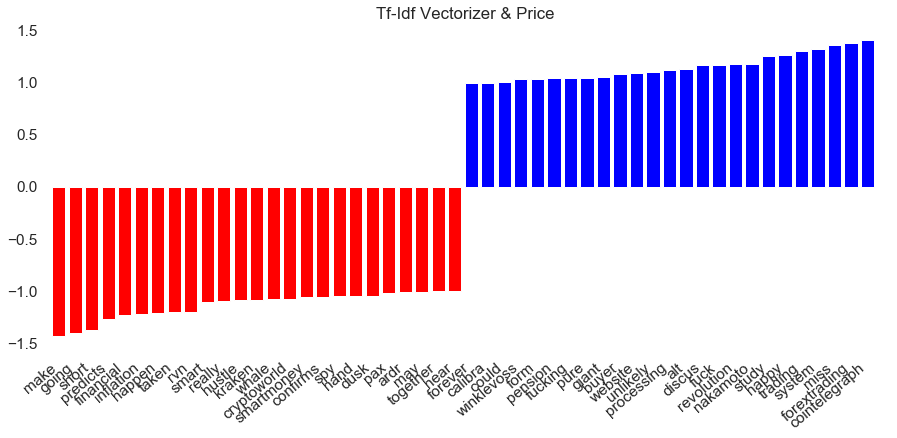

In [73]:
# plot the top 25 greatest absolute coefficient words in each side
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf.coef_.ravel(), np.array(feature_names), top_n=25, rotation=40)
_ = plt.title("Tf-Idf Vectorizer & Price")
ax = plt.gca()

#### 7.3 Count Vectorizer & Volume
- Score: 0.5108

The test score for Count Vectorizer & Volume is just 0.51, a little better than the random case. Not useful to explore.

In [74]:
# load_files returns a bunch, containing training texts and training labels
text_trainval, y_trainval = combined_df['clean_text'], combined_df['Volume_Trend']

#train_test_split
text_train, text_val, y_train, y_val = train_test_split(
    text_trainval, y_trainval,  shuffle=False)


In [75]:
# count vectirizer
vect = CountVectorizer(max_features=20000, token_pattern=r"\b\w+\b")
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)

In [76]:
# use Logistic Regression to train the text-volume model
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_val, y_val)

0.5107944732297064

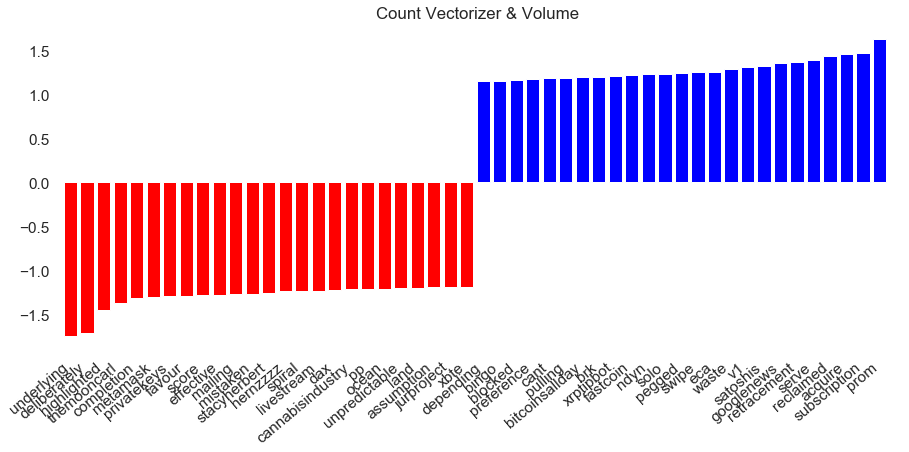

In [77]:
# feature names
feature_names = vect.get_feature_names()
# plot the top 25 greatest absolute coefficient words in each side
plt.figure(figsize=(15, 6))
plot_important_features(lr.coef_.ravel(), np.array(feature_names), top_n=25, rotation=40)
_ = plt.title("Count Vectorizer & Volume")
ax = plt.gca()

#### 7.4 Tfidf Vectorizer & Volume
- Score: 0.5194

The test score for Count Vectorizer & Volume is just 0.52, a little better than the random case. Not useful to explore.

In [78]:
# tf-idf model
tfidf = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf.fit_transform(text_train)
X_val_tfidf = tfidf.transform(text_val)

In [79]:
# use Logistic Regression to train the text-volume model
lr_tfidf = LogisticRegression().fit(X_train_tfidf, y_train)
lr_tfidf.score(X_val_tfidf, y_val)

0.5194300518134715

In [80]:
# get feature names
vac = tfidf.vocabulary_ 
sorted_vac = sorted(vac.items(), key=lambda kv: kv[1])
feature_names = [x[0] for x in sorted_vac]

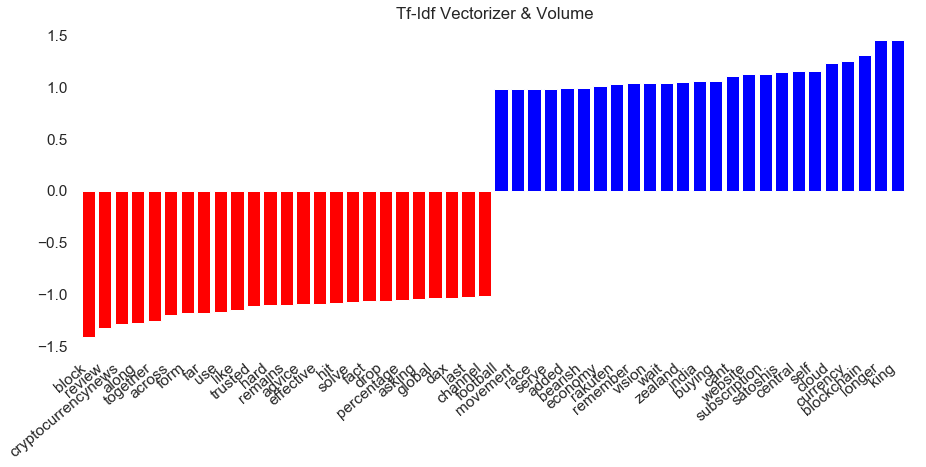

In [81]:
# plot the top 25 greatest absolute coefficient words in each side
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf.coef_.ravel(), np.array(feature_names), top_n=25, rotation=40)
_ = plt.title("Tf-Idf Vectorizer & Volume")
ax = plt.gca()

## 8. BTC Market vs. Tweets Attributes

- BTC Market:  
(1) Price(Close)  
(2) Volume  


- Tweets Attributes:  
(1) Tweets count  
(2) Sentiment Scores

We tried to utilize other tweet attributes we calculated, not just the tweet text itself. We got two important metrices from these data. The sentiment score and the tweet count.

1) To get the sentiment score metrice, we calculate the sentiment score for each twitter, multiplied by the logarithm (we can also use other functions) of number of followers of the user that posted this tweet. By doing so, we are trying to somehow measure the influence of each tweet, since tweet posted by different people tend to have different impact on market. Since the price data we get are of every minute, we also transformed the sentiment score into minutely data by summing up the score of all the tweets in each minute. (or we can use the mean)

2) We also calculate the number of tweets that were posted in each minute, named as tweets count
Here is a graph showing the change of sentiment score and price. We can see that for some short periods, like this, this and this, the trend of sentiment score could somehow indicate the following trend of price change. 



In [83]:
import plotly.graph_objs as go   #import graph objects as "go"
from datetime import datetime

In [84]:
initial_db2 = pd.read_csv("../data/btc_data_extraction/database/with_followers_fulltextscore.csv",index_col=0)
initial_db2['created_at'] = initial_db2['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
initial_db2.set_index("created_at",inplace=True)

In [85]:
initial_db2.head(2)

contributors coordinates display_text_range  \
created_at                                                         
2019-08-20 23:59:58           NaN         NaN           [0, 138]   
2019-08-20 23:59:52           NaN         NaN           [0, 223]   

                                                              entities  \
created_at                                                               
2019-08-20 23:59:58  {'hashtags': [{'text': 'BTC', 'indices': [7, 1...   
2019-08-20 23:59:52  {'hashtags': [{'text': 'bitcoin', 'indices': [...   

                    extended_entities  favorite_count  favorited  \
created_at                                                         
2019-08-20 23:59:58               NaN             0.0      False   
2019-08-20 23:59:52               NaN             9.0      False   

                                                             full_text  geo  \
created_at                                                                    
2019-08-20 23:59:58  $BTC | #BTC - bitcoin's Current Price: ▼ $1077...  NaN   
2019-08-20 23:59:52  🚨 CoinSpice Live is on the air, streaming now!...  NaN   

                                      id  ...  \
created_at                                ...   
2019-08-20 23:59:58             24411256  ...   
2019-08-20 23:59:52  1012928761254178816  ...   

                                                                source  \
created_at                                                               
2019-08-20 23:59:58  <a href="https://crypto.press" rel="nofollow">...   
2019-08-20 23:59:52  <a href="https://mobile.twitter.com" rel="nofo...   

                    truncated  \
created_at                      
2019-08-20 23:59:58     False   
2019-08-20 23:59:52     False   

                                                                  user  \
created_at                                                               
2019-08-20 23:59:58  {'id': 24411256, 'id_str': '24411256', 'name':...   
2019-08-20 23:59:52  {'id': 1012928761254178816, 'id_str': '1012928...   

                     withheld_in_countries  \
created_at                                   
2019-08-20 23:59:58                    NaN   
2019-08-20 23:59:52                    NaN   

                                                            clean_text  \
created_at                                                               
2019-08-20 23:59:58         btc btc bitcoin 's current price -0 -0 -0.   
2019-08-20 23:59:52  coinspice live air streaming tonight 're talki...   

                                                             sentiment  \
created_at                                                               
2019-08-20 23:59:58  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
2019-08-20 23:59:52  {'neg': 0.101, 'neu': 0.777, 'pos': 0.122, 'co...   

                     sentiment_comp sentiment_pos sentiment_neg followers  
created_at                                                                 
2019-08-20 23:59:58           0.000         0.000         0.000     60733  
2019-08-20 23:59:52          -0.327         0.122         0.101      2902  

[2 rows x 36 columns]

In [86]:
# Calculated multiplied sentiment score of each tweet
initial_db2['multiplied_senti'] = initial_db2['sentiment_comp']*np.log(initial_db2['followers']+1)

In [87]:
# group the initial_db2 for every 20 minutes and calculate some metrics
reformated_db_h = pd.DataFrame()
reformated_db_h['tweet_count'] = initial_db2['retweet_count'].resample('20T').count()#count the number of tweets
reformated_db_h['retweet_count'] = initial_db2['retweet_count'].resample('20T').sum()# sum up the retweet
reformated_db_h['favorite_count'] = initial_db2['favorite_count'].resample('20T').sum()# sum of the favorite
reformated_db_h['multiplied_senti'] = initial_db2['multiplied_senti'].resample('20T').sum()

reformated_db_h = reformated_db_h.reset_index()

In [88]:
reformated_db_h.head()

created_at  tweet_count  retweet_count  favorite_count  \
0 2019-08-11 23:00:00            4            0.0            13.0   
1 2019-08-11 23:20:00            4            6.0             5.0   
2 2019-08-11 23:40:00            3            4.0            15.0   
3 2019-08-12 00:00:00            4            0.0            14.0   
4 2019-08-12 00:20:00            3            0.0             0.0   

   multiplied_senti  
0          8.996377  
1         12.266491  
2          8.460261  
3         -4.452024  
4         -0.414904

In [89]:
btc_market = pd.read_csv("../data/btc_price_volume/gemini_BTCUSD_1min_0827.csv")
btc_market['Date'] = btc_market['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [90]:
# get the price and volume change as the new columns
btc_market['Price_Trend'] = btc_market['Close'].shift() <= btc_market['Close']
btc_market['Volume_Trend'] = btc_market['Volume'].shift() <= btc_market['Volume']
# repalce the values
btc_market['Price_Trend'] = btc_market['Price_Trend'].replace({True:1, False:0})
btc_market['Volume_Trend'] = btc_market['Volume_Trend'].replace({True:1, False:0})

In [91]:
btc_market.head(2)

Unix Timestamp                Date  Symbol      Open      High       Low  \
0   1566864180000 2019-08-27 00:03:00  BTCUSD  10374.59  10374.59  10365.85   
1   1566864120000 2019-08-27 00:02:00  BTCUSD  10379.19  10379.19  10374.59   

      Close    Volume  Price_Trend  Volume_Trend  
0  10365.85  0.044524            0             0  
1  10374.59  0.537898            1             1

In [92]:
reformated_db_h = pd.merge(reformated_db_h,btc_market[['Date','Close','Volume','Price_Trend','Volume_Trend']],
                           left_on='created_at',right_on='Date',how='left')

In [93]:
reformated_db_h.head(2)

created_at  tweet_count  retweet_count  favorite_count  \
0 2019-08-11 23:00:00            4            0.0            13.0   
1 2019-08-11 23:20:00            4            6.0             5.0   

   multiplied_senti                Date     Close    Volume  Price_Trend  \
0          8.996377 2019-08-11 23:00:00  11513.40  0.399628          1.0   
1         12.266491 2019-08-11 23:20:00  11505.33  0.000000          1.0   

   Volume_Trend  
0           1.0  
1           1.0

In [94]:
#save data and other metrics at twenty minutes' interval
reformated_db_h.to_csv("../data/btc_data_extraction/database/reformated_db_h.csv")

In [95]:

#read_result
reformated_db_h = pd.read_csv("../data/btc_data_extraction/database/reformated_db_h.csv",index_col=0)
reformated_db_h['created_at'] = reformated_db_h['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))


#### 8.1 Sentiment score vs. Price

In [96]:
trace3 = go.Scatter(
                    x = reformated_db_h['created_at'],
                    y = reformated_db_h['multiplied_senti'],
                    mode = "lines",
                    name = "Sentiment Score Compound Multiplied",
                    opacity = 1
                    )
# Creating trace2
trace2 = go.Scatter(
                    x = reformated_db_h['created_at'],
                    y = reformated_db_h['Close'],
                    mode = "lines",
                    name = "price",
                    yaxis = 'y2'
                    )

data = [trace3, trace2]

layout = go.Layout(
    title='Twitter text Sentiment Scores (log) & Price vs Time',
    yaxis=dict(
        title='Sentiment Score'
        
    ),
    yaxis2=dict(
        title='Price',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
        
    )
)

In [97]:

fig = go.Figure(data = data, layout = layout)
fig


#### 8.2 Tweet count vs. Price

In [98]:
trace1 = go.Scatter(
                    x = reformated_db_h['created_at'],
                    y = reformated_db_h['tweet_count'],
                    mode = "lines",
                    name = 'tweet_count'
                    )

# Creating trace2
trace2 = go.Scatter(
                    x = reformated_db_h['created_at'],
                    y = reformated_db_h['Close'],
                    mode = "lines",
                    name = "price",
                    yaxis = 'y2'
                    )

data = [ trace1, trace2]

layout = go.Layout(
    title='Tweet Count & Price vs Time',
    yaxis=dict(
        title='Tweet counts'
        
    ),
    yaxis2=dict(
        title='Price',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
        
    )
)

In [99]:
fig = go.Figure(data = data, layout = layout)
fig

## 8.3 Sentiment score vs. Volume

In [100]:
trace3 = go.Scatter(
                    x = reformated_db_h['created_at'],
                    y = reformated_db_h['multiplied_senti'],
                    mode = "lines",
                    name = "Sentiment Score Compound Multiplied",
                    opacity = 1
                    )
# Creating trace2
trace2 = go.Scatter(
                    x = reformated_db_h['created_at'],
                    y = reformated_db_h['Volume'],
                    mode = "lines",
                    name = "volume",
                    yaxis = 'y2'
                    )

data = [trace3, trace2]

layout = go.Layout(
    title='Twitter text Sentiment Scores (log) & Volume vs Time',
    yaxis=dict(
        title='Sentiment Score'
        
    ),
    yaxis2=dict(
        title='Volume',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
        
    )
)

In [101]:
fig = go.Figure(data = data, layout = layout)
fig.show()


## 8.4 Tweet count vs. Volume

In [102]:
trace3 = go.Scatter(
                    x = reformated_db_h['created_at'],
                    y = reformated_db_h['tweet_count'],
                    mode = "lines",
                    name = "tweet_count",
                    opacity = 1
                    )
# Creating trace2
trace2 = go.Scatter(
                    x = reformated_db_h['created_at'],
                    y = reformated_db_h['Volume'],
                    mode = "lines",
                    name = "volume",
                    yaxis = 'y2'
                    )

data = [trace3, trace2]

layout = go.Layout(
    title='Tweet Count & Volume vs Time',
    yaxis=dict(
        title='tweet count'
        
    ),
    yaxis2=dict(
        title='Volume',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
        
    )
)

In [103]:
fig = go.Figure(data = data, layout = layout)
fig.show()


## 9. Machine Learning Models

- BTC Market:    
(1) Price(Close)    
(2) Volume    


- Tweets Attributes:    
(1) Sentiment Score    
(2) Tweet Count

We divided the 927 records into training set of 698 records (75%) and testing set of 229 records (25%).

Using these two metrics, Sentiment Score and Tweet Count as explanatory factors, we make prediction for price trend with 6 machine learning models: K-Nearest Neighbours, Logistic Regression, Support Vector Machine, Multinomial Naive Bayes, Decision Tree and Random Forest 
For different length of lagging days, we feed corresponding data into our models, and here is the accuracy table. 

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn.svm import SVC #SVM
from sklearn.naive_bayes import MultinomialNB #Multinomial Naive Bayes
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree #Decision tree
#import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.model_selection import cross_val_score 

In [105]:
#read_result
reformated_db_h = pd.read_csv("../data/btc_data_extraction/database/reformated_db_h.csv",index_col=0)
reformated_db_h['created_at'] = reformated_db_h['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [106]:
reformated_db_h_ori=reformated_db_h.copy()
score_results=[]
for lag in range(-5,0):
    score_res=[]
    reformated_db_h=reformated_db_h_ori.copy()
    reformated_db_h['Price_Trend']=reformated_db_h['Price_Trend'].shift(lag)
    reformated_db_h.dropna(subset=["tweet_count","multiplied_senti",'Price_Trend'],inplace=True)
    x = np.array(reformated_db_h[["tweet_count","multiplied_senti"]]) #
    y = np.array(reformated_db_h['Price_Trend'])

    # from sklearn.model_selection import train_test_split

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42,shuffle=False)


    # from sklearn.neighbors import KNeighborsClassifier
    # from sklearn.model_selection import cross_val_score

    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(x_train, y_train) 
    neigh.score( x_test, y_test)
    neigh_cv = cross_val_score(neigh, x_train, y_train, cv=10) 
    score_res.append(neigh_cv.mean()) 
    # from sklearn.linear_model import LogisticRegression

    logreg = LogisticRegression(random_state=42)
    logreg.fit(x_train, y_train)
    logreg.score( x_test, y_test)
    logreg_cv = cross_val_score(logreg, x_train, y_train, cv=10)
    score_res.append(logreg_cv.mean())

    # from sklearn.svm import SVC

    svm_linear = SVC( kernel = 'linear')
    svm_linear.fit(x_train, y_train)
    svm_linear.score(x_test, y_test)
    svm_linear_cv = cross_val_score(svm_linear, x_train, y_train, cv=10)
    score_res.append(svm_linear_cv.mean())

    # from sklearn.naive_bayes import MultinomialNB

    # from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler() 
    X_minmax = scaler.fit_transform(x_train)

    mnb = MultinomialNB()

    mnb_cv = cross_val_score(mnb, X_minmax, y_train, cv=10) 
    score_res.append(mnb_cv.mean())

    # from sklearn import tree
    dtc = tree.DecisionTreeClassifier(random_state=42)
    dtc.fit(x_train, y_train) 
    dtc.score(x_test, y_test)

    dtc_cv = cross_val_score(dtc, x_train, y_train, cv=10) 
    score_res.append(dtc_cv.mean())

    # from sklearn.ensemble import RandomForestClassifier 

    forest_reg = RandomForestClassifier(random_state=42)
    forest_reg.fit(x_train, y_train)
    forest_reg.score(x_test, y_test)

    forest_reg_cv = cross_val_score(forest_reg, x_train, y_train, cv=10) 
    score_res.append(forest_reg_cv.mean())  
    score_results.append(score_res)

In [107]:
 pd.DataFrame(score_results,index=range(-5,0),columns=["KNN","Logistic","SVM","MNB","DTC","forest"])

KNN  Logistic       SVM       MNB       DTC    forest
-5  0.545794  0.658578  0.658578  0.658578  0.527224  0.548713
-4  0.585177  0.656244  0.659061  0.659061  0.556521  0.557912
-3  0.589864  0.652482  0.659544  0.659544  0.572699  0.589679
-2  0.532758  0.659544  0.659544  0.659544  0.522736  0.551394
-1  0.600119  0.660027  0.660027  0.660027  0.570222  0.587608

## 10. LSTM

- BTC Market:  
(1) Price(Close)  
(2) Volume  


- Tweets Attributes:  
(1) Sentiment Scores  
(2) Tweet counts

To acquire a higher accuracy, we tried the LSTM long short term memory model to make prediction based on sequence of values of dependent factors. For just a very simple LSTM model, like only one LSTM layer with 8 neurons, we get an accuracy of approximately 62%. We could say that we can make a somewhat reasonable prediction for the up and down of price using these two metrics. 

In [111]:
from keras.layers import Dense, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.utils import to_categorical

Using TensorFlow backend.


In [112]:
# Convert an array of values into a dataset matrix
def create_datasets(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-1):
        data_x.append(dataset[i:i+look_back, :-1])
        data_y.append(dataset[i + look_back, -1])
    return np.array(data_x), np.array(data_y)

In [113]:
reformated_db_h=reformated_db_h_ori.copy()
reformated_db_h=reformated_db_h[['tweet_count','multiplied_senti','Price_Trend']]

In [114]:
reformated_db_h.dropna(inplace=True)

In [115]:
look_back = 5 #the length of series to predict one output
num = 2 #dimension of input attributes

print('Normalizing data...\n')
# Normalize the price data set
#scaler = MinMaxScaler(feature_range=(0, 1))
all_dataset = reformated_db_h.values# scaler.fit_transform(all_data)

print('Training and Testing sets being created...\n')
# Split into train and test sets, 75% vs 25%
train_size = int(len(all_dataset)*0.75)

test_size = len(all_dataset) - train_size

train, test = all_dataset[:train_size, :], all_dataset[train_size:len(all_dataset), :]

# Reshape into train and test dataset
train_x, train_y = create_datasets(train, look_back)
test_x, test_y = create_datasets(test, look_back)
print("Training dataset dimensions {}".format(train_x.shape))
print("Testing dataset dimensions {}\n".format(test_x.shape))

# Reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], num))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], num))

# Create and fit the LSTM network
bitcoin_model = Sequential()
bitcoin_model.add(LSTM(8, input_shape=(train_x.shape[1], num)))
bitcoin_model.add(Dense(1,activation="sigmoid"))

bitcoin_model.compile(loss='binary_crossentropy', optimizer='adam')

print('Fitting LSTM Model...')
print('This can take a moment.\n')
bitcoin_model.fit(train_x, train_y, epochs=100, batch_size=100,verbose=0)

print('Calculating predictions...\n')
# Make predictions
train_prediction= bitcoin_model.predict_classes(train_x)
test_prediction = bitcoin_model.predict_classes(test_x)
score = bitcoin_model.evaluate(test_x, test_y)



Normalizing data...

Training and Testing sets being created...

Training dataset dimensions (698, 5, 2)
Testing dataset dimensions (229, 5, 2)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Fitting LSTM Model...
This can take a moment.


Calculating predictions...

229/229 [==============================] - 0s 469us/step


In [116]:
score

0.6218490725521437

## 10. Future Works & Conclusions

Social Media has already become a part of our daily life, it’s easy to know what other’s ideas and thoughts through social media. This project tried to investigate the relationship between twitter sentiment and volume with bitcoin market. Although there is no significant dependence been found between them, we did observe the correlation between the occurrence of certain words with the sentiment and bitcoin price change.

To further dive into the topic, some futures works can be considered to improve the results: 1) add emoji & emoticons in sentiment analysis; 2) build pipeline for real-time data collection and analysis; 3) expand the dataset from 15-days duration to several months, year level; 4) calculate other metrics with other attributes of twitter data; 5) include data from other social media resources, like google trend data (pytrends API), news title and article titles (newsapi API), etc.


## Reference
1. *An Introduction to Text Mining using Twitter Streaming API and Python.*
 21 July 2014, accessed 25 August 2019, http://adilmoujahid.com/posts/2014/07/twitter-analytics/.
2. *Extracting Twitter Data, Pre-Processing and Sentiment Analysis using Python 3.0.* 3 Apr 2019, accessed 25 August 2019, https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf.
3. *Analyzing Tweets with NLP in minutes with Spark, Optimus and Twint* 5 May 2018, assessed accessed 25 August 2019, https://towardsdatascience.com/analyzing-tweets-with-nlp-in-minutes-with-spark-optimus-and-twint-a0c96084995f.